# **Feature Selection via Mutual Information**

Feature selection is the process of identifying the most informative input variables (features) that contribute to predicting the output (target) in a model. Mutual Information (MI) is a powerful method for this purpose because it captures both **linear** and **non-linear** dependencies between features and the target.

---

## 1. **What is Mutual Information?**

Mutual Information is a **measure of dependence** between two random variables. It quantifies how much information one variable provides about another.

For two random variables $ X $ (input feature) and $ Y $ (target), the mutual information $ I(X; Y) $ is defined as:

$$
I(X; Y) = \int \int p(x, y) \log \left( \frac{p(x, y)}{p(x) p(y)} \right) \, dx \, dy \\
= S(X) +S(Y) - S(X,Y)
$$

Where:
- $p(x, y) = p(X=x, Y=y)$ is the **joint probability** distribution that $X=x$ and $Y=y$.
- $p(x)$ and $p(y)$ are the **marginal distributions** of $X$ and $Y$.
- The **log** is typically taken to the base 2 (measuring in bits) or natural log (nats).

### Intuitive Meaning:
- $I(X; Y) = 0 $: $ X $ and $ Y $ are **independent** (knowing $ X $ gives no information about $ Y $).
- Higher $ I(X; Y) $: Greater **dependency** between $ X $ and $ Y $ (knowing $ X $ reduces uncertainty about $ Y $).

Notice that when we say MI measures **dependency**, we mean a broader sense of statistical dependence, which includes and extends beyond simple correlations (remember that, in general, uncorrelation does **not** imply independence, as extensively discussed in https://en.wikipedia.org/wiki/Misconceptions_about_the_normal_distribution).

---

## 2. **Why Use Mutual Information for Feature Selection?**

Mutual Information provides a robust method for feature selection because:

1. **Captures Non-Linear Relationships**: Unlike correlation (which measures only linear dependency), MI identifies complex dependencies between variables.
   
2. **Model-Agnostic**: It does not assume any functional form (linear, polynomial, etc.), making it suitable for diverse types of data.

3. **Handles Redundant Features**: MI can reveal whether a feature adds unique information or overlaps with other features.

---

## 3. **Estimating Mutual Information from Data**

In practice, we rarely know the true probability distributions $p(x)$, $ p(y) $, and $ p(x, y) $. Instead, MI is estimated from **finite samples** using statistical approximations.

The `mutual_info_regression` function from `scikit-learn` uses a non-parametric method (i.e., **k-nearest neighbors (kNN)** entropy estimates) to estimate MI between each feature and the target.

Given a dataset $ \{ (x_{i,a}, y_i) \}_{i=1}^{N} $, the MI estimator calculates local densities to approximate how much knowing a feature reduces uncertainty about the target.

---

## 4. **Connection to Other Feature Selection Techniques**

- **Mutual Information vs. Correlation**:
  - Correlation captures **linear** dependency only.
  - MI captures **both linear and non-linear** dependencies.
  
- **Mutual Information vs. LASSO (L1 Regularization)**:
  - LASSO shrinks irrelevant feature weights but depends on the model’s functional form.
  - MI directly quantifies feature importance based on information content, independent of the modeling algorithm.

---

## 5. **Practical Considerations**
1. **Noise Sensitivity**: MI estimations can be sensitive to noise, so careful preprocessing is essential.
2. **Computational Cost**: Estimating MI using non-parametric methods can be **computationally intensive** for large datasets.
3. **Feature Interactions**: MI considers individual features independently. For complex feature interactions, **conditional** or **joint MI** may be required.

In [ ]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [ ]:
# DATA SUBDIVISION

# Load the California Housing dataset
california_housing = fetch_california_housing()

X = california_housing.data
y = california_housing.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# COMPUTING MI

# Compute mutual information scores on the training set
mi_scores = mutual_info_regression(X_train, y_train)

# Display the mutual information scores
feature_names = california_housing.feature_names
mi_scores_with_names = list(zip(feature_names, mi_scores))
mi_scores_with_names.sort(key=lambda x: x[1], reverse=True)

print("Feature Importance based on Mutual Information:")
for feature, score in mi_scores_with_names:
    print(f"{feature}: {score:.3f}")

# Questo codice organizza i risultati. Abbina i nomi delle feature ai loro punteggi MI,
# li ordina dal più alto al più basso, e li stampa in modo leggibile.

In [ ]:
mi_scores

array([0.38545051, 0.03438419, 0.10104781, 0.02535745, 0.02683595,
       0.07690673, 0.36464744, 0.39152853])

In [ ]:
california_housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [ ]:
# LASSO MODELIZATION

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Define a linear model with Lasso (L1 regularization) using Sklearn's Lasso
lasso_model = Lasso(alpha=0.01)  # Set alpha (regularization strength)


# alpha=0.01 è il parametro di regolarizzazione: più è alto, più il modello
# tenderà ad azzerare i coefficienti delle feature.

# Train the Lasso model
lasso_model.fit(X_train, y_train)

In [ ]:
# Evaluate the model on the test set
y_pred = lasso_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Test MSE: {mse:.4f}')

Test MSE: 0.5479


In [ ]:
# Evaluate the model on the train set
y_pred_train = lasso_model.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
print(f'Train MSE: {mse:.4f}')

Train MSE: 0.5237


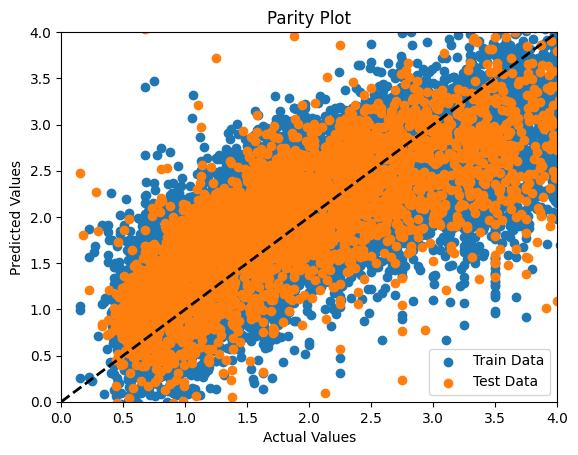

In [ ]:
# Draw a parity plot of y_train vs y_pred_train
import matplotlib.pyplot as plt
plt.scatter(y_train, y_pred_train, label='Train Data')
plt.scatter(y_test, y_pred, label='Test Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Parity Plot')
#draw 1:1 line with dashed style
plt.plot([0, 5], [0, 5], 'k--', lw=2)
plt.xlim(0,4)
plt.ylim(0,4)
plt.legend()
plt.show()

In [ ]:
# Extract and print the learned coefficients (weights)
weights = lasso_model.coef_

In [ ]:
print("\nLearned Coefficients:")
for feature, weight, mi_score in zip(feature_names, weights, mi_scores):
    print(f"{feature}: Coefficient = {weight:.4f}, MI Score = {mi_score:.4f}")



Learned Coefficients:
MedInc: Coefficient = 0.7953, MI Score = 0.3855
HouseAge: Coefficient = 0.1270, MI Score = 0.0344
AveRooms: Coefficient = -0.1594, MI Score = 0.1010
AveBedrms: Coefficient = 0.2163, MI Score = 0.0254
Population: Coefficient = -0.0000, MI Score = 0.0268
AveOccup: Coefficient = -0.0283, MI Score = 0.0769
Latitude: Coefficient = -0.7922, MI Score = 0.3646
Longitude: Coefficient = -0.7567, MI Score = 0.3915
